<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/PAWS_DR_fine_tune_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install --quiet -v --no-cache-dir ./

Cloning into 'apex'...
remote: Enumerating objects: 8054, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 8054 (delta 68), reused 101 (delta 47), pack-reused 7913
Receiving objects: 100% (8054/8054), 14.11 MiB | 26.23 MiB/s, done.
Resolving deltas: 100% (5467/5467), done.
/content/apex
Processing /content/apex
  Created wheel for apex: filename=apex-0.1-cp37-none-any.whl size=204709 sha256=f27901a150ec2a997fcbbbbe90ddfa6c17ab9e484d423cc691bb1302aa9a8de0
  Stored in directory: /tmp/pip-ephem-wheel-cache-d_8p24_a/wheels/b1/3a/aa/d84906eaab780ae580c7a5686a33bf2820d8590ac3b60d5967
Successfully built apex


In [2]:
cd ..

/content


In [3]:
!pip install --quiet -U PyYAML

     |████████████████████████████████| 645kB 5.1MB/s 


In [4]:
!git clone -b feature/DR-images-v2 https://github.com/jmarrietar/suncet.git

Cloning into 'suncet'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 332 (delta 196), reused 246 (delta 116), pack-reused 0
Receiving objects: 100% (332/332), 1.10 MiB | 14.32 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [5]:
cd suncet

/content/suncet


In [6]:
pwd

'/content/suncet'

In [7]:
import subprocess
import os

# Check whether the file is already in the desired path or if it needs to be downloaded
# File downloaded from source : https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data

base_path = '/content/suncet/datasets/dr/'
file_path = 'sample@1000.zip'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['mkdir', '-p', 'logs'])
    subprocess.call(['python', 'download.py', '-d', file_path.split('.')[0]])
else:
    print('File already downloaded!')

In [65]:
import gdown

output = "logs/paws-ep30.pth.tar" # CHANGE NAME
model_url = "https://drive.google.com/uc?id=1S0tpW0HDOzCkkwToWKfmPuAPASeCaMV3" # CHANGE URL

gdown.download(model_url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1S0tpW0HDOzCkkwToWKfmPuAPASeCaMV3
To: /content/suncet/logs/paws-ep30.pth.tar
306MB [00:01, 221MB/s]


'logs/paws-ep30.pth.tar'

`main.py`

In [66]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import argparse

import torch.multiprocessing as mp

import pprint
import yaml

from src.paws_train import main as paws
from src.suncet_train import main as suncet
from src.fine_tune import main as fine_tune
from src.snn_fine_tune import main as snn_fine_tune

from src.utils import init_distributed

parser = argparse.ArgumentParser()
parser.add_argument(
    "--fname", type=str, help="name of config file to load", default="configs.yaml"
)
parser.add_argument(
    "--devices",
    type=str,
    nargs="+",
    default=["cuda:0"],
    help="which devices to use on local machine",
)
parser.add_argument(
    "--sel",
    type=str,
    help="which script to run",
    choices=["paws_train", "suncet_train", "fine_tune", "snn_fine_tune"],
)


_StoreAction(option_strings=['--sel'], dest='sel', nargs=None, const=None, default=None, type=<class 'str'>, choices=['paws_train', 'suncet_train', 'fine_tune', 'snn_fine_tune'], help='which script to run', metavar=None)

In [67]:
args = parser.parse_args(['--sel', 'fine_tune',
                          '--fname', 'configs/paws/dr_fine_tune.yaml'
])

In [68]:
fname = args.fname
sel = args.sel

In [69]:
import logging
logging.basicConfig()
logger = logging.getLogger()

logger.info(f'called-params {sel} {fname}')

INFO:root:called-params fine_tune configs/paws/dr_fine_tune.yaml


In [70]:
rank = 0

In [71]:
# -- load script params
params = None
with open(fname, 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)
    logger.info('loaded params...')
    if rank == 0:
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(params)

if rank == 0:
    dump = os.path.join(params['logging']['folder'], f'params-{sel}.yaml')
    with open(dump, 'w') as f:
        yaml.dump(params, f)

INFO:root:loaded params...
{   'data': {   'data_seed': 152,
                'dataset': 'dr_fine_tune',
                'image_folder': 'dr/sample@1000/',
                'normalize': True,
                'num_classes': 2,
                'root_path': 'datasets/',
                'subset_path': 'dr_subsets/',
                'unlabeled_frac': 0.9},
    'logging': {   'folder': 'logs/',
                   'pretrain_path': 'paws-ep30.pth.tar',
                   'write_tag': 'paws-latest-SNN'},
    'meta': {   'copy_data': True,
                'device': 'cuda:0',
                'load_checkpoint': False,
                'master_port': 4029,
                'model_name': 'resnet50',
                'training': True,
                'use_fp16': True},
    'optimization': {   'epochs': 5,
                        'lr': 1e-05,
                        'use_lars': False,
                        'weight_decay': 0.0,
                        'zero_init': True}}


In [72]:
args = params

In [73]:
args

{'data': {'data_seed': 152,
  'dataset': 'dr_fine_tune',
  'image_folder': 'dr/sample@1000/',
  'normalize': True,
  'num_classes': 2,
  'root_path': 'datasets/',
  'subset_path': 'dr_subsets/',
  'unlabeled_frac': 0.9},
 'logging': {'folder': 'logs/',
  'pretrain_path': 'paws-ep30.pth.tar',
  'write_tag': 'paws-latest-SNN'},
 'meta': {'copy_data': True,
  'device': 'cuda:0',
  'load_checkpoint': False,
  'master_port': 4029,
  'model_name': 'resnet50',
  'training': True,
  'use_fp16': True},
 'optimization': {'epochs': 5,
  'lr': 1e-05,
  'use_lars': False,
  'weight_decay': 0.0,
  'zero_init': True}}

# FINE TUNE TRAIN

In [74]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

import os

# -- FOR DISTRIBUTED TRAINING ENSURE ONLY 1 DEVICE VISIBLE PER PROCESS
try:
    # -- WARNING: IF DOING DISTRIBUTED TRAINING ON A NON-SLURM CLUSTER, MAKE
    # --          SURE TO UPDATE THIS TO GET LOCAL-RANK ON NODE, OR ENSURE
    # --          THAT YOUR JOBS ARE LAUNCHED WITH ONLY 1 DEVICE VISIBLE
    # --          TO EACH PROCESS
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['SLURM_LOCALID']
except Exception:
    pass

import logging
import sys
import copy

from collections import OrderedDict

import numpy as np

import torch

import src.resnet as resnet
import src.wide_resnet as wide_resnet
from src.utils import (
    init_distributed,
    WarmupCosineSchedule
)
from src.data_manager import (
    init_data,
    make_transforms
)
from src.sgd import SGD
from torch.nn.parallel import DistributedDataParallel
from src.lars import LARS

# --
log_timings = True
log_freq = 10
checkpoint_freq = 50
# --

_GLOBAL_SEED = 0
np.random.seed(_GLOBAL_SEED)
torch.manual_seed(_GLOBAL_SEED)
torch.backends.cudnn.benchmark = True

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()

In [75]:
def load_pretrained(
    r_path,
    encoder,
    device_str
):
    checkpoint = torch.load(r_path, map_location='cpu')
    pretrained_dict = {k.replace('module.', ''): v for k, v in checkpoint['encoder'].items()}
    for k, v in encoder.state_dict().items():
        if k not in pretrained_dict:
            logger.info(f'key "{k}" could not be found in loaded state dict')
        elif pretrained_dict[k].shape != v.shape:
            logger.info(f'key "{k}" is of different shape in model and loaded state dict')
            pretrained_dict[k] = v
    msg = encoder.load_state_dict(pretrained_dict, strict=False)
    logger.info(f'loaded pretrained model with msg: {msg}')
    logger.info(f'loaded pretrained encoder from epoch: {checkpoint["epoch"]} '
                f'path: {r_path}')
    del checkpoint
    return encoder

In [76]:
def load_from_path(
    r_path,
    encoder,
    opt,
    sched,
    scaler,
    device_str,
    use_fp16=False
):
    encoder = load_pretrained(r_path, encoder, device_str)
    checkpoint = torch.load(r_path, map_location=device_str)

    best_acc = None
    if 'best_top1_acc' in checkpoint:
        best_acc = checkpoint['best_top1_acc']

    epoch = checkpoint['epoch']
    if opt is not None:
        if use_fp16:
            scaler.load_state_dict(checkpoint['amp'])
        opt.load_state_dict(checkpoint['opt'])
        sched.load_state_dict(checkpoint['sched'])
        logger.info(f'loaded optimizers from epoch {epoch}')
    logger.info(f'read-path: {r_path}')
    del checkpoint
    return encoder, opt, sched, epoch, best_acc

In [77]:
def init_model(
    device,
    device_str,
    num_classes,
    training,
    use_fp16,
    r_enc_path,
    iterations_per_epoch,
    world_size,
    ref_lr,
    num_epochs,
    use_lars=False,
    zero_init=True,
    model_name='resnet50',
    warmup_epochs=0,
    weight_decay=0
):
    # -- init model
    if 'wide_resnet' in model_name:
        encoder = wide_resnet.__dict__[model_name](dropout_rate=0.0)
        hidden_dim = 128
    else:
        encoder = resnet.__dict__[model_name]()
        hidden_dim = 2048
        if 'w2' in model_name:
            hidden_dim *= 2
        elif 'w4' in model_name:
            hidden_dim *= 4

    # -- projection head
    encoder.fc = torch.nn.Sequential(OrderedDict([
        ('fc1', torch.nn.Linear(hidden_dim, hidden_dim)),
        ('bn1', torch.nn.BatchNorm1d(hidden_dim)),
        ('relu1', torch.nn.ReLU(inplace=True)),
        ('fc2', torch.nn.Linear(hidden_dim, 1)), # YO changed
        ('sg', torch.nn.Sigmoid())  # YO 
    ]))

    encoder.to(device)
    encoder = load_pretrained(
        r_path=r_enc_path,
        encoder=encoder,
        device_str=device_str)

    if zero_init:
        for p in encoder.fc.fc2.parameters():
            torch.nn.init.zeros_(p)

    # -- init optimizer
    optimizer, scheduler = None, None
    if training:
        param_groups = [
            {'params': (p for n, p in encoder.named_parameters()
                        if ('bias' not in n) and ('bn' not in n))},
            {'params': (p for n, p in encoder.named_parameters()
                        if ('bias' in n) or ('bn' in n)),
             'LARS_exclude': True,
             'weight_decay': 0}
        ]
        optimizer = SGD(
            param_groups,
            nesterov=True,
            weight_decay=weight_decay,
            momentum=0.9,
            lr=ref_lr)
        scheduler = WarmupCosineSchedule(
            optimizer,
            warmup_steps=warmup_epochs*iterations_per_epoch,
            start_lr=ref_lr,
            ref_lr=ref_lr,
            T_max=num_epochs*iterations_per_epoch)
        if use_lars:
            optimizer = LARS(optimizer, trust_coefficient=0.001)
    if world_size > 1:
        encoder = DistributedDataParallel(encoder, broadcast_buffers=False)

    return encoder, optimizer, scheduler

In [78]:
# -- META
model_name = args['meta']['model_name']
port = args['meta']['master_port']
load_checkpoint = args['meta']['load_checkpoint']
training = args['meta']['training']
copy_data = args['meta']['copy_data']
use_fp16 = args['meta']['use_fp16']
device = torch.device(args['meta']['device'])
torch.cuda.set_device(device)

In [79]:
# -- DATA
unlabeled_frac = args['data']['unlabeled_frac']
normalize = args['data']['normalize']
root_path = args['data']['root_path']
image_folder = args['data']['image_folder']
dataset_name = args['data']['dataset']
subset_path = args['data']['subset_path']
num_classes = args['data']['num_classes']
data_seed = None
if 'cifar10' in dataset_name:
    data_seed = args['data']['data_seed']
crop_scale = (0.5, 1.0) if 'cifar10' in dataset_name else (0.08, 1.0)

In [80]:
# -- OPTIMIZATION
wd = float(args['optimization']['weight_decay'])
ref_lr = args['optimization']['lr']
use_lars = args['optimization']['use_lars']
zero_init = args['optimization']['zero_init']
num_epochs = args['optimization']['epochs']

In [81]:
# -- LOGGING
folder = args['logging']['folder']
tag = args['logging']['write_tag']
r_file_enc = args['logging']['pretrain_path']

In [82]:
# -- log/checkpointing paths
r_enc_path = os.path.join(folder, r_file_enc)
w_enc_path = os.path.join(folder, f'{tag}-fine-tune.pth.tar')

In [83]:
# -- init distributed
world_size, rank = init_distributed(port)
logger.info(f'initialized rank/world-size: {rank}/{world_size}')

INFO:root:distributed training not available
INFO:root:initialized rank/world-size: 0/1


In [84]:
# -- optimization/evaluation params
if training:
    batch_size = 32
else:
    batch_size = 16
    unlabeled_frac = 0.0
    load_checkpoint = True
    num_epochs = 1

In [85]:
# -- init loss
#criterion = torch.nn.CrossEntropyLoss() 
criterion = torch.nn.BCELoss() # YO CHANGED HERE
#criterion = torch.nn.BCEWithLogitsLoss()

In [86]:
# -- make train data transforms and data loaders/samples
transform, init_transform = make_transforms(
    dataset_name=dataset_name,
    subset_path=subset_path,
    unlabeled_frac=unlabeled_frac,
    training=training,
    crop_scale=crop_scale,
    split_seed=data_seed,
    basic_augmentations=True,
    normalize=normalize)

INFO:root:making imagenet data transforms
INFO:root:keep file: dr_subsets/90percent.txt


In [87]:
(data_loader,
    dist_sampler) = init_data(
        dataset_name=dataset_name,
        transform=transform,
        init_transform=init_transform,
        u_batch_size=None,
        s_batch_size=batch_size,
        classes_per_batch=2,
        world_size=world_size,
        rank=rank,
        root_path=root_path,
        image_folder=image_folder,
        training=training,
        copy_data=copy_data)

INFO:root:copying data locally
INFO:root:No job-id, will load directly from network file
INFO:root:data-path datasets/dr/sample@1000/train/
INFO:root:Initialized ImageDR
INFO:root:ImageNet fine-tune dataset created
self.multicrop_transform (0, None)
INFO:root:flipping coin to keep labels


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [88]:
ipe = len(data_loader)
logger.info(f'initialized data-loader (ipe {ipe})')

INFO:root:initialized data-loader (ipe 3)


In [89]:
# -- init model and optimizer
scaler = torch.cuda.amp.GradScaler(enabled=use_fp16)
encoder, optimizer, scheduler = init_model(
    device=device,
    device_str=args['meta']['device'],
    num_classes=num_classes,
    training=training,
    use_fp16=use_fp16,
    r_enc_path=r_enc_path,
    iterations_per_epoch=ipe,
    world_size=world_size,
    ref_lr=ref_lr,
    weight_decay=wd,
    use_lars=use_lars,
    zero_init=zero_init,
    num_epochs=num_epochs,
    model_name=model_name)

INFO:root:key "fc.fc2.weight" is of different shape in model and loaded state dict
INFO:root:key "fc.fc2.bias" is of different shape in model and loaded state dict
INFO:root:loaded pretrained model with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['pred.bn1.weight', 'pred.bn1.bias', 'pred.bn1.running_mean', 'pred.bn1.running_var', 'pred.bn1.num_batches_tracked', 'pred.fc1.weight', 'pred.fc1.bias', 'pred.bn2.weight', 'pred.bn2.bias', 'pred.bn2.running_mean', 'pred.bn2.running_var', 'pred.bn2.num_batches_tracked', 'pred.fc2.weight', 'pred.fc2.bias', 'fc.bn2.weight', 'fc.bn2.bias', 'fc.bn2.running_mean', 'fc.bn2.running_var', 'fc.bn2.num_batches_tracked', 'fc.fc3.weight', 'fc.fc3.bias'])
INFO:root:loaded pretrained encoder from epoch: 30 path: logs/paws-ep30.pth.tar


In [90]:
encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [91]:
best_acc = None
start_epoch = 0
# -- load checkpoint
if not training or load_checkpoint:
    encoder, optimizer, scheduler, start_epoch, best_acc = load_from_path(
        r_path=w_enc_path,
        encoder=encoder,
        opt=optimizer,
        sched=scheduler,
        scaler=scaler,
        device_str=args['meta']['device'],
        use_fp16=use_fp16)
if not training:
    logger.info('putting model in eval mode')
    encoder.eval()
    logger.info(sum(p.numel() for n, p in encoder.named_parameters()
                    if p.requires_grad and ('fc' not in n)))
    start_epoch = 0

In [92]:
num_epochs = 5

In [93]:
for epoch in range(start_epoch, num_epochs):

    def train_step():
        # -- update distributed-data-loader epoch
        top1_correct, total = 0, 0
        for i, data in enumerate(data_loader):
            with torch.cuda.amp.autocast(enabled=False): # Yo
                inputs, labels = data[0].to(device), data[1].to(device)

                labels = labels.unsqueeze(1) ## YO
                labels = labels.float() ## YO

                outputs = encoder(inputs)
                loss = criterion(outputs, labels)
            total += inputs.shape[0]
            top1_correct += float(sum(((outputs>0.5)*1 == labels)*1))
            top1_acc = 100. * (top1_correct / total)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
            if i % log_freq == 0:
                logger.info('[%d, %5d] %.3f%% (loss: %.3f)'
                            % (epoch + 1, i, top1_acc, loss))
        return 100. * (top1_correct / total)

    train_top1 = 0.
    train_top1 = train_step()

    log_str = 'train:'
    logger.info('[%d] (%s: %.3f%%) '
                % (epoch + 1, log_str, train_top1))

    # -- logging/checkpointing
    if rank == 0:

        save_dict = {
            'encoder': encoder.state_dict(),
            'opt': optimizer.state_dict(),
            'sched': scheduler.state_dict(),
            'epoch': epoch + 1,
            'unlabel_prob': unlabeled_frac,
            'world_size': world_size,
            'batch_size': batch_size,
            'lr': ref_lr,
            'amp': scaler.state_dict()
        }
        torch.save(save_dict, w_enc_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


INFO:root:[1,     0] 50.000% (loss: 0.693)
INFO:root:[1] (train:: 64.583%) 
INFO:root:[2,     0] 75.000% (loss: 0.693)
INFO:root:[2] (train:: 75.000%) 
INFO:root:[3,     0] 68.750% (loss: 0.692)
INFO:root:[3] (train:: 69.792%) 
INFO:root:[4,     0] 71.875% (loss: 0.691)
INFO:root:[4] (train:: 70.833%) 
INFO:root:[5,     0] 71.875% (loss: 0.690)
INFO:root:[5] (train:: 73.958%) 


## Script

In [ ]:
pwd

'/content'

In [ ]:
cd suncet

/content/suncet


In [40]:
!python main.py --sel fine_tune --fname configs/paws/dr_fine_tune.yaml

INFO:root:called-params fine_tune configs/paws/dr_fine_tune.yaml
INFO:root:loaded params...
{   'data': {   'data_seed': 152,
                'dataset': 'dr_fine_tune',
                'image_folder': 'dr/sample@1000/',
                'normalize': True,
                'num_classes': 2,
                'root_path': 'datasets/',
                'subset_path': 'dr_subsets/',
                'unlabeled_frac': 0.9},
    'logging': {   'folder': 'logs/',
                   'pretrain_path': 'paws-ep30.pth.tar',
                   'write_tag': 'paws-latest-SNN'},
    'meta': {   'copy_data': True,
                'device': 'cuda:0',
                'load_checkpoint': False,
                'master_port': 4029,
                'model_name': 'resnet50',
                'training': True,
                'use_fp16': True},
    'optimization': {   'epochs': 5,
                        'lr': 1e-05,
                        'use_lars': False,
                        'weight_decay': 0.0,
             

## Test PAWS

In [144]:
# Didnt work using this I would need to fix it in order to use it. 
"""
import src.resnet as resnet

device = "cuda:0"
device_str = "cuda:0"

folder = "suncet/logs/"
r_file_enc = "paws-ep30.pth.tar" # CHANGE

# -- log/checkpointing paths
r_enc_path = os.path.join(folder, r_file_enc)
w_enc_path = os.path.join(folder, f'{tag}-fine-tune.pth.tar')

encoder = resnet.__dict__["resnet50"]()

hidden_dim = 2048
if 'w2' in model_name:
    hidden_dim *= 2
elif 'w4' in model_name:
    hidden_dim *= 4

# -- projection head
encoder.fc = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(hidden_dim, hidden_dim)),
    ('bn1', torch.nn.BatchNorm1d(hidden_dim)),
    ('relu1', torch.nn.ReLU(inplace=True)),
    ('fc2', torch.nn.Linear(hidden_dim, 1)), # YO changed
    ('sg', torch.nn.Sigmoid())  # YO 
]))

encoder = load_pretrained(
    r_path=r_enc_path,
    encoder=encoder,
    device_str=device_str)
"""

INFO:root:key "fc.fc2.weight" is of different shape in model and loaded state dict
INFO:root:key "fc.fc2.bias" is of different shape in model and loaded state dict
INFO:root:loaded pretrained model with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['pred.bn1.weight', 'pred.bn1.bias', 'pred.bn1.running_mean', 'pred.bn1.running_var', 'pred.bn1.num_batches_tracked', 'pred.fc1.weight', 'pred.fc1.bias', 'pred.bn2.weight', 'pred.bn2.bias', 'pred.bn2.running_mean', 'pred.bn2.running_var', 'pred.bn2.num_batches_tracked', 'pred.fc2.weight', 'pred.fc2.bias', 'fc.bn2.weight', 'fc.bn2.bias', 'fc.bn2.running_mean', 'fc.bn2.running_var', 'fc.bn2.num_batches_tracked', 'fc.fc3.weight', 'fc.fc3.bias'])
INFO:root:loaded pretrained encoder from epoch: 30 path: suncet/logs/paws-ep30.pth.tar


------------

In [118]:
encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [123]:
test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

In [126]:
!gdown $URL_TEST_DATASET

Downloading...
From: https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p
To: /content/messidor2.zip
106MB [00:00, 229MB/s] 


In [127]:
import zipfile

In [128]:
local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [129]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [130]:
import torchvision.transforms as transforms

In [131]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # What happens if I change This 
])

In [134]:
#cd ..

In [135]:
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

In [137]:
test_dataset = datasets.ImageFolder(root="messidor2", transform=transform_val) # root: test/messidor2

In [138]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False)

loader = test_loader

In [145]:
model = encoder

In [146]:
y_true = []
y_pred = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            output = output.to(device)

            # Yo le agrege esto
            y_true.append(targets.cpu().detach().numpy()[0])
            y_pred.append(output.cpu().detach().numpy()[0][0])

            pbar.update(1)

  0%|          | 0/1748 [00:00<?, ?it/s]


RuntimeError: ignored

In [141]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.7128241381963681

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


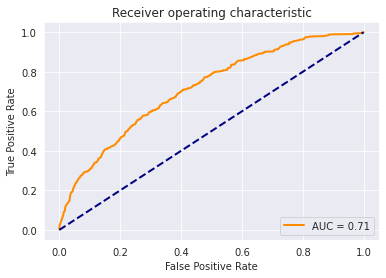

In [142]:
# Commented out IPython magic to ensure Python compatibility.
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
# %matplotlib inline

#cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
#print('AUC: %.3f' % auc)
#print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()